Instructions:

- Build upon the classification completed in the mini-project, adding additional modeling from new classification algorithms
- Add explanations that are inline with the CRISP-DM framework.
- Use appropriate cross validation for all of your analysis. Explain your chosen method of performance validation in detail.
- Try to use as much testing data as possible in a realistic manner. Define what you think
is realistic and why.

- Identify two tasks from the dataset to regress or classify. That is:  
  - two classification tasks OR
  - two regression tasks OR
  - one classification task and one regression task  
- Example from the diabetes dataset:
  (1) Classify if a patient will be readmitted within a 30 day period or not.
  (2) Regress what the total number of days a patient will spend in the hospital, given their history and specifics of the encounter like tests administered and previous admittance.

### Setup and Data Import

In [1]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import time

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor, Lasso, LassoCV
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from sklearn import metrics as mt
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Display plots inline
%matplotlib inline

# Load dataset
df = pd.read_csv('data/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Data Preparation: Classification Task

- Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
- Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created).

#### Data Cleaning & Preprocessing

In [2]:
# Make a copy of the dataset
df_clean = df.copy()

# Replace '?' with NaN
df_clean.replace('?', np.nan, inplace=True)

# Fill missing values
df_clean[['medical_specialty', 'payer_code', 'race']] = df_clean[['medical_specialty', 'payer_code', 'race']].fillna('Unknown')
df_clean[['diag_1', 'diag_2', 'diag_3']] = df_clean[['diag_1', 'diag_2', 'diag_3']].fillna('Unknown/None')
df_clean[['max_glu_serum', 'A1Cresult']] = df_clean[['max_glu_serum', 'A1Cresult']].fillna('Untested')

# Convert numeric categorical columns to strings explicitly (not category yet)
numeric_categorical_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df_clean[numeric_categorical_cols] = df_clean[numeric_categorical_cols].astype(str)

# Drop unnecessary columns
df_clean.drop(columns=['encounter_id', 'examide', 'citoglipton', 'weight', 'patient_nbr'], inplace=True)

# Define ordinal category orders
category_orders = {
    'readmitted': ['<30', '>30', 'NO'],
    'max_glu_serum': ['Untested', 'Norm', '>200', '>300'],
    'A1Cresult': ['Untested', 'Norm', '>7', '>8'],
    'age': ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
            '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
}

# Convert ordinal variables
for col, order in category_orders.items():
    df_clean[col] = pd.Categorical(df_clean[col], categories=order, ordered=True)

# Convert drug variables to ordinal categories
drug_order = ['No', 'Down', 'Steady', 'Up']
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide', 
                'pioglitazone', 'rosiglitazone', 'troglitazone', 'acarbose', 'miglitol', 
                'insulin', 'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'glimepiride-pioglitazone']
for col in drug_cols:
    df_clean[col] = pd.Categorical(df_clean[col], categories=drug_order, ordered=True)

# Preprocess diag_1, diag_2, diag_3 combining all codes with decimals under their integer values
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_clean[col] = df_clean[col].str.split('.').str[0]  # Drop decimals and digits after

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  category
 3   admission_type_id         101766 non-null  object  
 4   discharge_disposition_id  101766 non-null  object  
 5   admission_source_id       101766 non-null  object  
 6   time_in_hospital          101766 non-null  int64   
 7   payer_code                101766 non-null  object  
 8   medical_specialty         101766 non-null  object  
 9   num_lab_procedures        101766 non-null  int64   
 10  num_procedures            101766 non-null  int64   
 11  num_medications           101766 non-null  int64   
 12  number_outpatient         101766 non-null  int64   
 13  number_emergency          101

#### Feature Engineering & Selection

In [3]:
# Extract response variable
y = df_clean['readmitted']
X = df_clean.drop(columns=['readmitted'])

# Convert target variable to a binary numeric (1 for 'Yes', 0 for 'No')
y_binary = y.copy()
y_binary = np.where(y == '<30', 1, 0)


## Feature Selection from RF Variable Importance (Done in EDA)
rf_features_js = ['num_lab_procedures', 'diag_1', 'diag_2', 'diag_3', 'num_medications', 'time_in_hospital', 'age', 
                  'number_inpatient', 'medical_specialty', 'discharge_disposition_id', 'payer_code', 'num_procedures', 
                  'number_diagnoses', 'admission_type_id', 'admission_source_id']
rf_features_kh = ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'number_inpatient', 'number_diagnoses', 
                  'num_procedures', 'number_outpatient', 'number_emergency', 'diag_3', 'gender', 'diag_1', 'medical_specialty', 
                  'diag_2', 'payer_code', 'race', 'discharge_disposition_id']

# Get the union of both feature lists (combined RF-selected features)
rf_features_all = list(set(rf_features_js) | set(rf_features_kh))

print(f"Total RF-Selected Features ({len(rf_features_all)}): {rf_features_all}")

# Alternatively, we could take only the common features
# rf_features_common = list(set_js & set_kh)  # OR use set_js.intersection(set_kh)
# print(f"\nFeatures in both RF lists ({len(rf_features_common)}):\n", rf_features_common)

# Create a Reduced Dataset with RF-Selected Features
X_rf_selected = X[rf_features_all].copy()

# Define categorical and numerical feature subsets
categorical_cols = X_rf_selected.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_rf_selected.select_dtypes(include=['int64', 'float64']).columns

# One-Hot Encoding categorical variables (tried OneHotEncoder in a ColumnTransformer but ran into trouble)
X_encoded = pd.get_dummies(X_rf_selected, columns=categorical_cols, drop_first=True)  # drop_first for multicollinearity issues - log reg

# # Function to group ICD-9 codes to avoid unseen categories
# def map_icd9_group(code):
#     try:
#         if code.startswith('V') or code.startswith('E'):
#             return 'External'
#         elif code.isdigit():
#             code = int(code)
#             if 1 <= code <= 139:
#                 return 'Infectious'
#             elif 140 <= code <= 239:
#                 return 'Neoplasms'
#             elif 240 <= code <= 279:
#                 return 'Endocrine/Metabolic'
#             elif 280 <= code <= 289:
#                 return 'Blood Disorders'
#             elif 290 <= code <= 319:
#                 return 'Mental Disorders'
#             elif 320 <= code <= 389:
#                 return 'Neurological/Sensory'
#             elif 390 <= code <= 459:
#                 return 'Circulatory'
#             elif 460 <= code <= 519:
#                 return 'Respiratory'
#             elif 520 <= code <= 579:
#                 return 'Digestive'
#             elif 580 <= code <= 629:
#                 return 'Genitourinary'
#             elif 630 <= code <= 679:
#                 return 'Pregnancy'
#             elif 680 <= code <= 709:
#                 return 'Skin'
#             elif 710 <= code <= 739:
#                 return 'Musculoskeletal'
#             elif 740 <= code <= 759:
#                 return 'Congenital'
#             elif 760 <= code <= 779:
#                 return 'Perinatal'
#             elif 780 <= code <= 799:
#                 return 'Symptoms/Signs'
#             elif 800 <= code <= 999:
#                 return 'Injury'
#         return 'Unknown'
#     except:
#         return 'Unknown'

# # Apply to diagnosis columns
# for col in ['diag_1', 'diag_2', 'diag_3']:
#     X_rf_selected.loc[:, col] = X_rf_selected[col].astype(str).apply(map_icd9_group)


# # Replace rare categories (enhanced for numeric IDs)
# def replace_rare_categories(df, categorical_cols, threshold):
#     df = df.copy()
#     for col in categorical_cols:
#         freq = df[col].value_counts()
#         rare_categories = freq[freq < threshold].index.tolist()
#         df[col] = df[col].replace(rare_categories, 'Other')
#         # Explicitly group uncommon numeric IDs if still present
#         # if col in ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']:
#         #     df[col] = df[col].apply(lambda x: x if freq.get(x, 0) >= threshold else 'Other')
#     return df

# X_rf_selected = replace_rare_categories(X_rf_selected, categorical_cols, threshold=10)

# Apply StandardScaler only to numerical columns while keeping categorical (one-hot encoded) features unchanged
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_cols)], remainder='passthrough')


Total RF-Selected Features (19): ['number_inpatient', 'diag_2', 'race', 'age', 'admission_source_id', 'num_procedures', 'num_lab_procedures', 'time_in_hospital', 'gender', 'number_emergency', 'number_diagnoses', 'num_medications', 'diag_3', 'admission_type_id', 'number_outpatient', 'payer_code', 'medical_specialty', 'diag_1', 'discharge_disposition_id']


## Modeling and Evaluation: Classification Task

- Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.
- Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.
- Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
- Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.
- Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

#### Creating a Stratified Holdout Test Set

In [4]:
# Split into train (80%) and holdout test (20%) - Stratified
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_binary, test_size=0.2, stratify=y_binary, random_state=1234)


#### Define Classifiers

In [5]:
# Define Classifiers
clf_lr = SGDClassifier(loss="log_loss", penalty="l2", alpha=1e-05, eta0=0.01,
                       max_iter=1000, class_weight="balanced",
                       learning_rate="adaptive", n_jobs=-1, random_state=1234)
clf_nb = MultinomialNB(alpha=0.5)  # Tune alpha later
clf_dt = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=1, class_weight='balanced'),
                            learning_rate=0.5, # Tune small to prevent overfitting and larger to increase contribution of each classifier
                            n_estimators=500)  # Tune estimators later 

# Define classifier labels
clf_labels = ['SGD Logistic Regression', 'Multinomial Naive Bayes', 'AdaBoost Decision Tree']

# Pipelines
clf_lr_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', clf_lr)])
# clf_nb # No scaling needed
clf_dt_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', clf_dt)])


#### Tune Hyperparameters

In [6]:
# Hyperparameter tuning for MultinomialNB
start_time = time.time()

param_grid_nb = {
    'alpha': np.arange(0.1, 1.1, 0.1),
    'class_prior': [(0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6)]  # Yes=11%
}

grid_nb = GridSearchCV(
    clf_nb, param_grid_nb, cv=5, scoring=['accuracy', 'recall', 'f1'], refit='f1',
    return_train_score=True
)
grid_nb.fit(X_train, y_train)

# Print accuracy and recall for each hyperparameter combination
print("\nMultinomialNB - Hyperparameter Performance:")
for alpha, class_prior, acc, rec, f1 in zip(
    grid_nb.cv_results_['param_alpha'],
    grid_nb.cv_results_['param_class_prior'],
    grid_nb.cv_results_['mean_test_accuracy'],
    grid_nb.cv_results_['mean_test_recall'],
    grid_nb.cv_results_['mean_test_f1']
):
    print(f"Alpha: {alpha}, Class Prior: {class_prior}, Accuracy: {acc:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

# Get best alpha and class_prior
best_alpha = grid_nb.best_params_['alpha']
best_class_prior = grid_nb.best_params_['class_prior']
print(f"\nBest alpha for MNB: {best_alpha}, Best class prior: {best_class_prior}")

# Update NB classifier with best hyperparameters
clf_nb = MultinomialNB(alpha=best_alpha, class_prior=best_class_prior)

print(f"NB Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for AdaBoost
start_time = time.time()

param_grid_ab = {'clf__n_estimators': [50, 150, 300],
                 'clf__learning_rate': [0.1, 0.5, 1.0, 1.5]}

grid_ab = GridSearchCV(
    clf_dt_pipeline, param_grid_ab, cv=3, scoring=['accuracy', 'recall', 'f1'], refit='f1',
    return_train_score=True
)
grid_ab.fit(X_train, y_train)

# Print accuracy and recall for each hyperparameter combination
print("\nAdaBoost - Hyperparameter Performance:")
for n_estimators, learning_rate, acc, rec, f1 in zip(
    grid_ab.cv_results_['param_clf__n_estimators'], 
    grid_ab.cv_results_['param_clf__learning_rate'],
    grid_ab.cv_results_['mean_test_accuracy'],
    grid_ab.cv_results_['mean_test_recall'],
    grid_ab.cv_results_['mean_test_f1']
):
    print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, Accuracy: {acc:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

# Get best n_estimators and learning_rate
best_n_estimators = grid_ab.best_params_['clf__n_estimators']
best_learning_rate = grid_ab.best_params_['clf__learning_rate']
print(f"\nBest n_estimators for AdaBoost: {best_n_estimators}, Best learning_rate: {best_learning_rate}")

# Update AdaBoost classifier with best n_estimators
clf_dt_pipeline.set_params(clf__n_estimators=best_n_estimators)
clf_dt_pipeline.set_params(clf__learning_rate=best_learning_rate)

print(f"AdaBoost Tuning Time: {(time.time() - start_time)/60:.2f} minutes")



MultinomialNB - Hyperparameter Performance:
Alpha: 0.1, Class Prior: (0.1, 0.9), Accuracy: 0.2075, Recall: 0.9558, F1: 0.2121
Alpha: 0.1, Class Prior: (0.2, 0.8), Accuracy: 0.3485, Recall: 0.8588, F1: 0.2273
Alpha: 0.1, Class Prior: (0.3, 0.7), Accuracy: 0.4874, Recall: 0.7398, F1: 0.2436
Alpha: 0.1, Class Prior: (0.4, 0.6), Accuracy: 0.5990, Recall: 0.6207, F1: 0.2568
Alpha: 0.2, Class Prior: (0.1, 0.9), Accuracy: 0.2014, Recall: 0.9619, F1: 0.2119
Alpha: 0.2, Class Prior: (0.2, 0.8), Accuracy: 0.3466, Recall: 0.8635, F1: 0.2278
Alpha: 0.2, Class Prior: (0.3, 0.7), Accuracy: 0.4870, Recall: 0.7405, F1: 0.2437
Alpha: 0.2, Class Prior: (0.4, 0.6), Accuracy: 0.5998, Recall: 0.6205, F1: 0.2571
Alpha: 0.30000000000000004, Class Prior: (0.1, 0.9), Accuracy: 0.1975, Recall: 0.9638, F1: 0.2114
Alpha: 0.30000000000000004, Class Prior: (0.2, 0.8), Accuracy: 0.3455, Recall: 0.8626, F1: 0.2273
Alpha: 0.30000000000000004, Class Prior: (0.3, 0.7), Accuracy: 0.4878, Recall: 0.7406, F1: 0.2440
Alpha

#### Cross-Validate Classifiers (SGD Logistic Regression, Multinomial Naive Bayes, and AdaBoost Decision Tree)

In [7]:
start_time_total = time.time()  # Track total time

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Dictionary to store model training times
cv_times = {}

# Cross-validation: Recall, Accuracy, F1
print("\n10-fold Cross-Validation Metrics:\n")
for clf, label in zip([clf_lr_pipeline, clf_nb, clf_dt_pipeline], clf_labels):
    
    start_time = time.time()  # Start timing for the model
    
    recall_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='recall', n_jobs=-1)
    f1_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='f1', n_jobs=-1)
    accuracy_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='accuracy', n_jobs=-1)

    end_time = time.time()  # End timing
    
    # Store elapsed time in minutes
    cv_times[label] = (end_time - start_time) / 60 
    
    print(f"{label}:")
    print(f"  CV Recall: {recall_scores.mean():.2f} (+/- {recall_scores.std():.2f})")
    print(f"  CV F1 Score: {f1_scores.mean():.2f} (+/- {f1_scores.std():.2f})")
    print(f"  CV Accuracy: {accuracy_scores.mean():.2f} (+/- {accuracy_scores.std():.2f})\n")


# Print Cross-Validation Timing Per Model
print("\nCross-Validation Time per Model (in minutes):")
for model, time_taken in cv_times.items():
    print(f"{model}: {time_taken:.2f} minutes")

# Print Total Time Taken
end_time_total = time.time()
print(f"\nTotal Elapsed Time for Cross-Validation: {(end_time_total - start_time_total)/60:.2f} minutes")



10-fold Cross-Validation Metrics:

SGD Logistic Regression:
  CV Recall: 0.56 (+/- 0.02)
  CV F1 Score: 0.27 (+/- 0.01)
  CV Accuracy: 0.66 (+/- 0.01)

Multinomial Naive Bayes:
  CV Recall: 0.62 (+/- 0.02)
  CV F1 Score: 0.26 (+/- 0.01)
  CV Accuracy: 0.60 (+/- 0.01)

AdaBoost Decision Tree:
  CV Recall: 0.28 (+/- 0.01)
  CV F1 Score: 0.24 (+/- 0.01)
  CV Accuracy: 0.81 (+/- 0.00)


Cross-Validation Time per Model (in minutes):
SGD Logistic Regression: 5.38 minutes
Multinomial Naive Bayes: 0.34 minutes
AdaBoost Decision Tree: 1.22 minutes

Total Elapsed Time for Cross-Validation: 6.94 minutes


#### Evaluate Classifiers on the Holdout Set


Performance Metrics for SGD Logistic Regression:
  Precision: 0.1772
  Recall: 0.5632
  F1 Score: 0.2696
  Accuracy: 0.6595
  ROC AUC: 0.6656

Performance Metrics for Multinomial Naive Bayes:
  Precision: 0.1641
  Recall: 0.6328
  F1 Score: 0.2607
  Accuracy: 0.5995
  ROC AUC: 0.6545

Performance Metrics for AdaBoost Decision Tree:
  Precision: 0.2073
  Recall: 0.2664
  F1 Score: 0.2332
  Accuracy: 0.8045
  ROC AUC: 0.6027


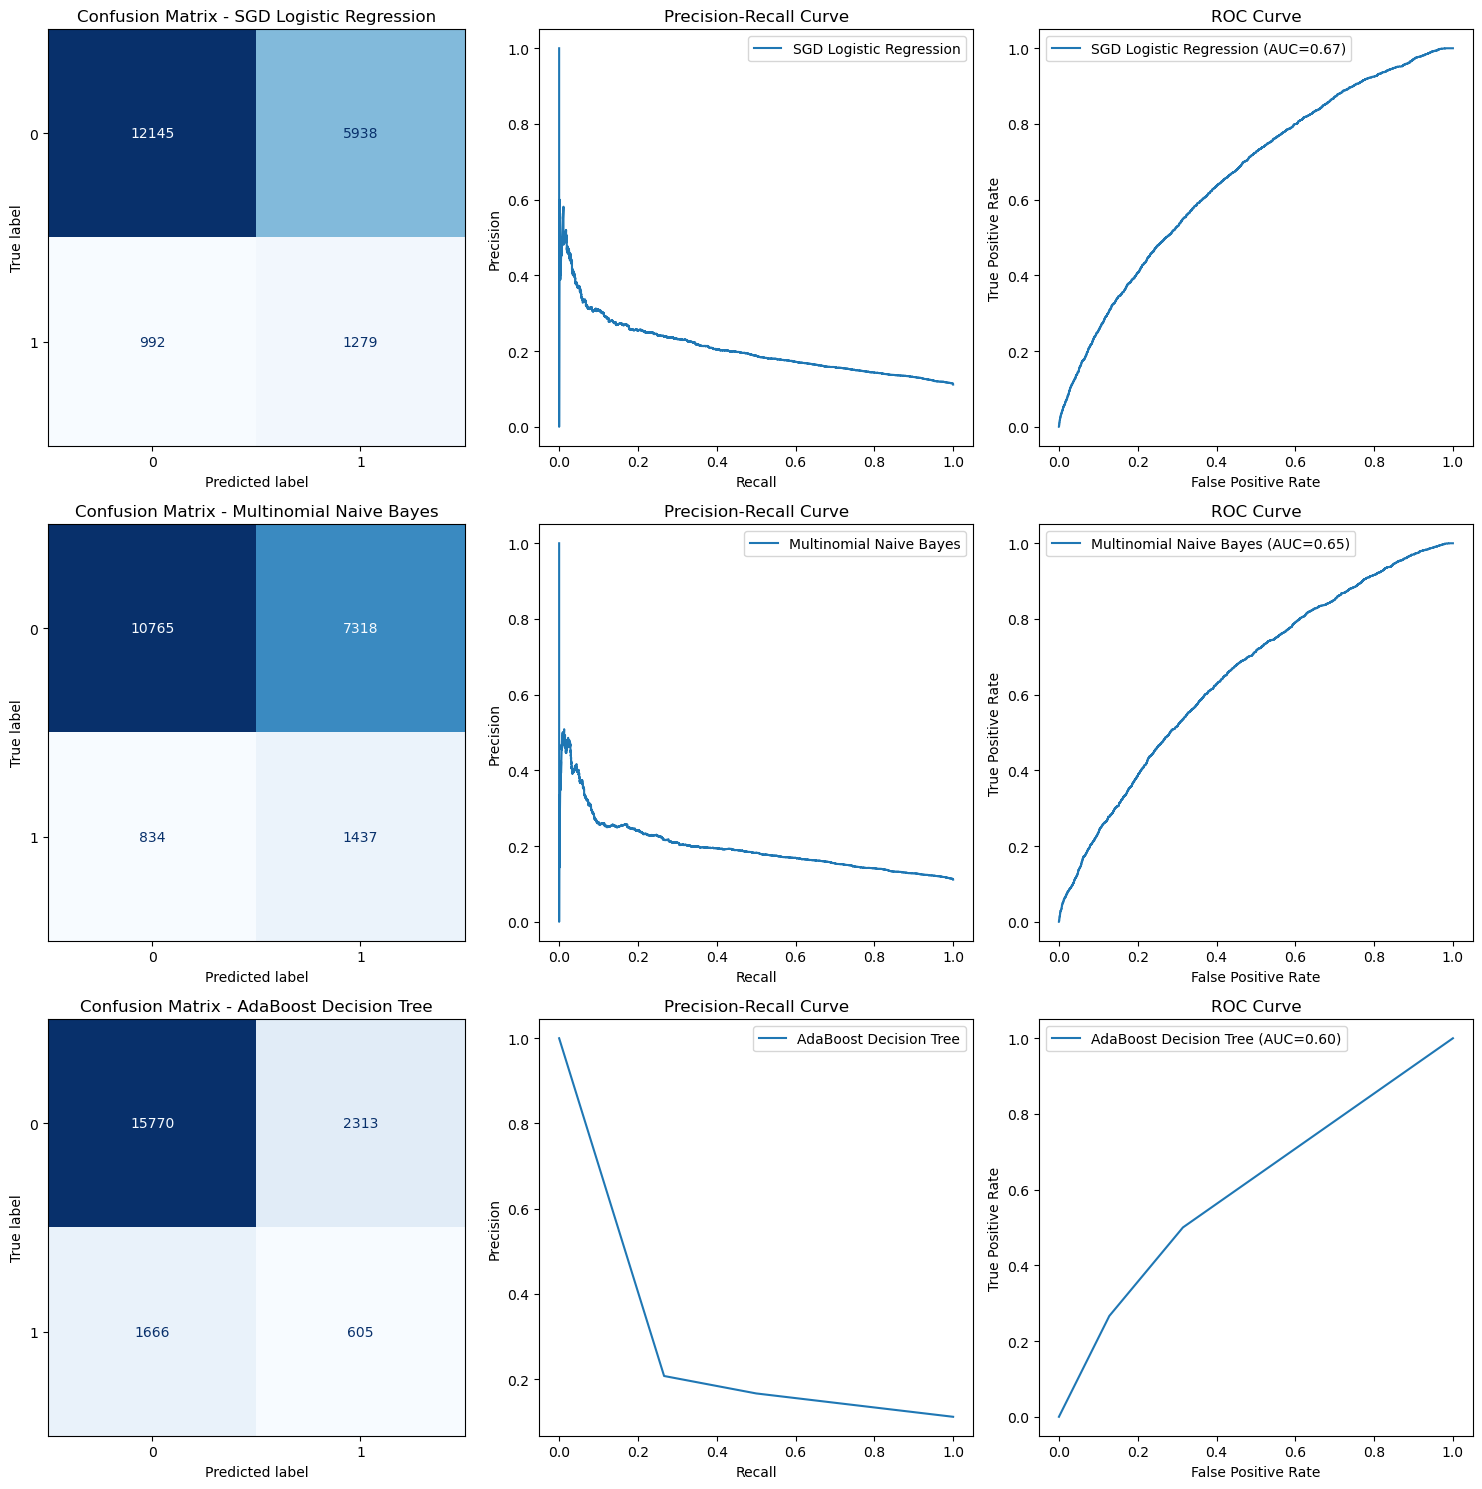

In [8]:
# Fit the models
clf_lr_pipeline.fit(X_train, y_train)
clf_nb.fit(X_train, y_train)
clf_dt_pipeline.fit(X_train, y_train)

# Create subplots for CM, PR, and ROC curves
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3 rows, 3 columns (CM, PR, ROC)

for i, (clf, label) in enumerate(zip([clf_lr_pipeline, clf_nb, clf_dt_pipeline], clf_labels)):
    
    # Predictions
    y_test_pred = clf.predict(X_test)
    y_test_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for positive class

    # Confusion Matrix
    cm_test = mt.confusion_matrix(y_test, y_test_pred)
    cm_display = mt.ConfusionMatrixDisplay(cm_test)
    axes[i, 0].set_title(f"Confusion Matrix - {label}")
    cm_display.plot(ax=axes[i, 0], cmap="Blues", colorbar=False)

    # Precision-Recall Curve
    precision, recall, _ = mt.precision_recall_curve(y_test, y_test_prob)
    axes[i, 1].plot(recall, precision, label=f"{label}")
    axes[i, 1].set_title("Precision-Recall Curve")
    axes[i, 1].set_xlabel("Recall")
    axes[i, 1].set_ylabel("Precision")
    axes[i, 1].legend(loc="best")

    # ROC Curve
    fpr, tpr, _ = mt.roc_curve(y_test, y_test_prob)
    axes[i, 2].plot(fpr, tpr, label=f"{label} (AUC={mt.roc_auc_score(y_test, y_test_prob):.2f})")
    axes[i, 2].set_title("ROC Curve")
    axes[i, 2].set_xlabel("False Positive Rate")
    axes[i, 2].set_ylabel("True Positive Rate")
    axes[i, 2].legend(loc="best")

    # Print final metrics for comparison
    print(f"\nPerformance Metrics for {label}:")
    print(f"  Precision: {mt.precision_score(y_test, y_test_pred):.4f}")
    print(f"  Recall: {mt.recall_score(y_test, y_test_pred):.4f}")
    print(f"  F1 Score: {mt.f1_score(y_test, y_test_pred):.4f}")
    print(f"  Accuracy: {mt.accuracy_score(y_test, y_test_pred):.4f}")
    print(f"  ROC AUC: {mt.roc_auc_score(y_test, y_test_prob):.4f}")

plt.tight_layout()
plt.show()


## Data Preparation: Regression Task

- Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
- Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created).


#### Preprocessing & Encoding

In [9]:
# Get a copy of the data prior preprocessing for classification
df2 = df_clean.copy()

# Extract response variable
y_time = df2['time_in_hospital']
X_time = df2.drop(columns=['time_in_hospital'])

# Define categorical and numerical feature subsets
categorical_cols = X_time.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_time.select_dtypes(include=['int64', 'float64']).columns

# One-Hot Encoding categorical variables
X_time_encoded = pd.get_dummies(X_time, columns=categorical_cols, drop_first=True)  # drop_first for multicollinearity issues

# Define the preprocessing pipeline
# Apply StandardScaler only to numerical columns while keeping categorical (one-hot encoded) features unchanged
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_cols)], remainder='passthrough')


#### Review Summary Statistics of the Response


Summary Statistics for 'time_in_hospital':
count    101766.000000
mean          4.395987
std           2.985108
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          14.000000
Name: time_in_hospital, dtype: float64


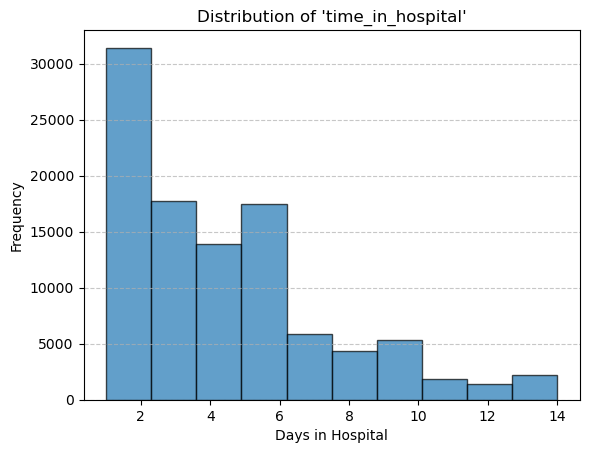

In [10]:
# Display summary statistics for the response variable
y_summary = y_time.describe()

# Print summary statistics
print("\nSummary Statistics for 'time_in_hospital':")
print(y_summary)

# Plot distribution of response variable
plt.figure()
plt.hist(y_time, edgecolor='black', alpha=0.7)
plt.xlabel("Days in Hospital")
plt.ylabel("Frequency")
plt.title("Distribution of 'time_in_hospital'")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Split the Data into a Training and Holdout Set Prior to Feature Selection

In [11]:
# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_time_encoded, y_time, test_size=0.2, random_state=1234)


#### Feature Selection

In [12]:
# ----- LASSO Feature Selection -----
start_time = time.time()

lasso_selector = LassoCV(cv=5, random_state=1234)

# Create a pipeline with preprocessing and LASSO
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', lasso_selector)
])

# Fit the pipeline
lasso_pipeline.fit(X_train, y_train)

# Retrieve feature names after transformation
feature_names = numerical_cols.tolist() + [col for col in X_train.columns if col not in numerical_cols]

# Select features with non-zero coefficients
lasso_selected_features = [feature_names[i] for i in range(len(feature_names)) if lasso_selector.coef_[i] != 0]

print(f"LASSO time: {(time.time() - start_time)/60:.2f} minutes")

# ----- Random Forest Feature Selection -----
start_time = time.time()

rf_selector = RandomForestRegressor(n_estimators=100, random_state=1234)
rf_selector.fit(X_train, y_train)

# Get feature importances and select top features
feature_importances = pd.Series(rf_selector.feature_importances_, index=X_train.columns)
rf_selected_features = feature_importances[feature_importances > np.percentile(feature_importances, 75)].index.tolist()  # Top 25% features

print(f"RF time: {(time.time() - start_time)/60:.2f} minutes")

# - `lasso_selected_features` is the list of features selected by LASSO
# - `rf_selected_features` is the list of features selected by Random Forest
# - `X_time` is the original dataset before encoding
# - `categorical_cols` and `numerical_cols` are already defined

# Convert feature lists to DataFrames for processing
lasso_df = pd.DataFrame({'Feature': lasso_selected_features})
rf_df = pd.DataFrame({'Feature': rf_selected_features})

# ----- Extract Original Variable Names for LASSO -----
lasso_numeric = lasso_df['Feature'][lasso_df['Feature'].isin(numerical_cols)]
lasso_categorical = lasso_df['Feature'][~lasso_df['Feature'].isin(numerical_cols)]
lasso_original_categorical = lasso_categorical.str.replace(r'_[^_]+$', '', regex=True)  # Remove one-hot encoding suffixes

# Combine numeric and cleaned categorical features
lasso_unique_features = pd.concat([lasso_numeric, lasso_original_categorical]).unique()

# ----- Extract Original Variable Names for Random Forest -----
rf_numeric = rf_df['Feature'][rf_df['Feature'].isin(numerical_cols)]
rf_categorical = rf_df['Feature'][~rf_df['Feature'].isin(numerical_cols)]
rf_original_categorical = rf_categorical.str.replace(r'_[^_]+$', '', regex=True)

# Combine numeric and cleaned categorical features
rf_unique_features = pd.concat([rf_numeric, rf_original_categorical]).unique()

# ----- Find Common & Unused Features -----
dataset_features = pd.Series(X_time.columns)  # Original dataset BEFORE encoding

# Features selected by both LASSO & RF
common_features = pd.Series(list(set(lasso_unique_features) & set(rf_unique_features)))

# Features in dataset but not selected by either method
unused_features = dataset_features[~dataset_features.isin(pd.concat([pd.Series(lasso_unique_features), pd.Series(rf_unique_features)]))]

# Print Results
print("\nLASSO Unique Selected Features (Original Variables):")
print(lasso_unique_features)

print("\nRandom Forest Unique Selected Features (Original Variables):")
print(rf_unique_features)

print("\nCommon Features Selected by Both LASSO and RF:")
print(common_features.to_list())

print("\nUnused Features (Present in Dataset but NOT Selected by LASSO or RF):")
print(unused_features.to_list())


LASSO time: 0.37 minutes
RF time: 7.19 minutes

LASSO Unique Selected Features (Original Variables):
['num_lab_procedures' 'num_procedures' 'num_medications'
 'number_outpatient' 'number_emergency' 'number_inpatient'
 'number_diagnoses' 'race' 'age' 'admission_type_id'
 'discharge_disposition_id' 'admission_source_id' 'payer_code'
 'medical_specialty' 'diag_1' 'diag_2' 'diag_3' 'max_glu_serum'
 'A1Cresult' 'metformin' 'repaglinide' 'glimepiride' 'glipizide'
 'glyburide' 'pioglitazone' 'rosiglitazone' 'insulin' 'change'
 'diabetesMed' 'readmitted']

Random Forest Unique Selected Features (Original Variables):
['num_lab_procedures' 'num_procedures' 'num_medications'
 'number_outpatient' 'number_emergency' 'number_inpatient'
 'number_diagnoses' 'race' 'gender' 'age' 'admission_type_id'
 'discharge_disposition_id' 'admission_source_id' 'payer_code'
 'medical_specialty' 'diag_1' 'diag_2' 'diag_3' 'max_glu_serum'
 'A1Cresult' 'metformin' 'repaglinide' 'nateglinide' 'glimepiride'
 'glipizide'

#### Create a Reduced Dataset with Important Variables

In [13]:
# Train/test split was already created. Do this to avoid leakage.

# Identify encoded features corresponding to lasso-selected original features
selected_encoded_features = [col for col in X_train.columns if any(feature in col for feature in lasso_unique_features)]

# Create a Reduced Dataset with Encoded Features
X_train_selected = X_train[selected_encoded_features].copy()
X_test_selected = X_test[selected_encoded_features].copy()  # Ensure same columns in test set

# Ensure train and test have the same columns (Test set may lack some categories)
X_test_selected = X_test_selected.reindex(columns=X_train_selected.columns, fill_value=0)

# Final check
print("Final Training Shape:", X_train_selected.shape)
print("Final Testing Shape:", X_test_selected.shape)


Final Training Shape: (81412, 2362)
Final Testing Shape: (20354, 2362)


## Modeling and Evaluation: Regression Task

- Choose and explain your evaluation metrics that you will use. Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.
- Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.
- Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
- Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.
- Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

#### Hyperparameter Tuning

In [14]:
# ---- Hyperparameter Tuning for LASSO ----
start_time = time.time()

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], cv=5, random_state=1234)) # Use LassoCV instead of GridSearch
])

lasso_pipeline.fit(X_train_selected, y_train)

# Get best alpha directly from LassoCV
best_alpha = lasso_pipeline.named_steps['reg'].alpha_
print(f"\nBest Alpha for LASSO: {best_alpha}")

print(f"LASSO tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for Random Forest ----
start_time = time.time()

rf_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [10, 20, None],  
    'min_samples_split': [5, 10],  
    'min_samples_leaf': [2, 5],  
    'max_features': ['sqrt']  
}

# Use RandomizedSearchCV for efficiency
grid_rf = RandomizedSearchCV(RandomForestRegressor(random_state=1234), 
                             param_distributions=rf_grid, n_iter=7, cv=5, 
                             scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train_selected, y_train)

# Get best RF parameters
best_rf_params = grid_rf.best_params_
print(f"\nBest Parameters for Random Forest: {best_rf_params}")

print(f"RF tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for SVR (RBF) ----
# For comparison with SGDRegressor (linear), RBF is computationally too expensive with full dataset
start_time = time.time()

svr_sample = X_train_selected.sample(n=min(5000, len(X_train_selected)), random_state=1234)
y_svr_sample = y_train.loc[svr_sample.index]

param_grid_svr = {
    'reg__C': [0.1, 1, 10],
    'reg__gamma': ['scale', 'auto'],
    'reg__epsilon': [0.1, 0.2, 0.5]
}

svr_pipeline = Pipeline([('preprocessor', preprocessor), ('reg', SVR(kernel='rbf'))])
grid_svr = GridSearchCV(svr_pipeline, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=2)
grid_svr.fit(svr_sample, y_svr_sample)

# Extract best parameters
best_C = grid_svr.best_params_['reg__C']
best_epsilon = grid_svr.best_params_['reg__epsilon']
print(f"\nBest SVR Parameters: C={best_C}, epsilon={best_epsilon}, Kernel=rbf")
print(f"SVR tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for SGDRegressor----
start_time = time.time()

param_grid_sgd = {
    'reg__alpha': [0.0001, 0.001, 0.01, 0.1],
    'reg__max_iter': [10000, 20000],
    'reg__tol': [1e-2, 1e-3],
    'reg__learning_rate': ['constant', 'optimal', 'invscaling']
}

sgd_pipeline = Pipeline([('preprocessor', preprocessor), ('reg', SGDRegressor(random_state=1234, early_stopping=True))])
grid_sgd = GridSearchCV(sgd_pipeline, param_grid_sgd, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_sgd.fit(svr_sample, y_svr_sample) # Use the same sample of 5000 as used for tuning the SVR

best_sgd_params = grid_sgd.best_params_
print(f"\nBest Parameters for SGDRegressor: {best_sgd_params}")
print(f"SGDRegressor tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for XGBoost ----
# Preprocessing fixes
# Ensure column names are strings
X_train_selected.columns = X_train_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
X_test_selected.columns = X_test_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
# # Ensure y_train is a 1D array
# y_train = y_train.ravel()

start_time = time.time()

xgb_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

grid_xgb = RandomizedSearchCV(XGBRegressor(tree_method='hist', random_state=1234), 
                              param_distributions=xgb_grid, n_iter=7, cv=5, 
                              scoring='neg_mean_squared_error')
grid_xgb.fit(X_train_selected, y_train)

# Get best XGBoost parameters
best_xgb_params = grid_xgb.best_params_
print(f"\nBest Parameters for XGBoost: {best_xgb_params}")
print(f"XGBoost tuning time: {(time.time() - start_time)/60:.2f} minutes")



Best Alpha for LASSO: 0.0001
LASSO tuning time: 0.99 minutes

Best Parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
RF tuning time: 1.22 minutes

Best SVR Parameters: C=10, epsilon=0.5, Kernel=rbf
SVR tuning time: 5.29 minutes

Best Parameters for SGDRegressor: {'reg__alpha': 0.001, 'reg__learning_rate': 'invscaling', 'reg__max_iter': 10000, 'reg__tol': 0.001}
SGDRegressor tuning time: 0.11 minutes

Best Parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2}
XGBoost tuning time: 2.53 minutes


#### Hyperparameter Tuning Details

In [15]:
# ---- Display LASSO Tuning Results ----
lasso_cv = lasso_pipeline.named_steps['reg']  # Extract the LassoCV model

lasso_results = pd.DataFrame({
    'Alpha': lasso_cv.alphas_,
    'Mean MSE': lasso_cv.mse_path_.mean(axis=1),  
    'Std MSE': lasso_cv.mse_path_.std(axis=1)  
})

lasso_results.sort_values(by='Mean MSE', ascending=True, inplace=True)  # Lower MSE is better
print("\nLASSO Hyperparameter Tuning Results:")
print(lasso_results)


# ---- Display Random Forest Tuning Results ----
rf_results = pd.DataFrame(grid_rf.cv_results_)
rf_results = rf_results[[
    'param_n_estimators', 'param_max_depth',
    'param_min_samples_split', 'param_min_samples_leaf',
    'param_max_features', 'mean_test_score', 'std_test_score'
]]
rf_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
rf_results.sort_values(by='Mean MSE', ascending=False, inplace=True)  # Higher neg MSE is better
print("\nRandom Forest Hyperparameter Tuning Results:")
print(rf_results)


# ---- Display SVR Tuning Results ----
svr_results = pd.DataFrame(grid_svr.cv_results_)
svr_results = svr_results[[
    'param_reg__C', 'param_reg__gamma', 'param_reg__epsilon',
    'mean_test_score', 'std_test_score'
]]
svr_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
svr_results.sort_values(by='Mean MSE', ascending=False, inplace=True)  
print("\nSVR Hyperparameter Tuning Results:")
print(svr_results)


# ---- Display SGDRegressor Tuning Results ----
sgd_results = pd.DataFrame(grid_sgd.cv_results_)
sgd_results = sgd_results[[
    'param_reg__alpha', 'param_reg__max_iter', 'param_reg__tol', 'param_reg__learning_rate',
    'mean_test_score', 'std_test_score'
]]
sgd_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
sgd_results.sort_values(by='Mean MSE', ascending=False, inplace=True)
print("\nSGDRegressor Hyperparameter Tuning Results:")
print(sgd_results)


# ---- Display XGBoost Tuning Results ----
xgb_results = pd.DataFrame(grid_xgb.cv_results_)
xgb_results = xgb_results[[
    'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample',
    'mean_test_score', 'std_test_score'
]]
xgb_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
xgb_results.sort_values(by='Mean MSE', ascending=False, inplace=True)
print("\nXGBoost Hyperparameter Tuning Results:")
print(xgb_results)



LASSO Hyperparameter Tuning Results:
      Alpha  Mean MSE   Std MSE
6    0.0001  4.922157  0.061825
5    0.0010  5.006710  0.065134
4    0.0100  5.466042  0.073354
3    0.1000  6.520046  0.097922
2    1.0000  7.997807  0.105850
0  100.0000  8.937581  0.105310
1   10.0000  8.937581  0.105310

Random Forest Hyperparameter Tuning Results:
   param_n_estimators param_max_depth  param_min_samples_split  \
2                  50            None                       10   
4                  50            None                        5   
3                 200            None                       10   
0                  50              20                        5   
1                 100              20                       10   
5                  50              10                       10   
6                 100              10                       10   

   param_min_samples_leaf param_max_features  Mean MSE   Std MSE  
2                       2               sqrt -5.610386  0.105913

#### Fit and Evaluate Regression Models on the Holdout Set

In [16]:
start_time_total = time.time()  # Track total time

# Define model labels
reg_labels = ['LASSO Regression', 'Random Forest Regression', 'SGD Regression', 'XGBoost']

# Store training and prediction times
model_times = {"Training Time (min)": {}, "Prediction Time (sec)": {}}


# ---- Update pipelines with with best parameters ----
# Update Lasso pipeline
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', Lasso(alpha=best_alpha, random_state=1234))  # Use Lasso (not LassoCV)
])

# Update RF model with modified best parameters, set n_estimators manually (error/time tradeoff isn't worth it)
# Remove "reg__" prefix from best parameters
best_rf_params_cleaned = {k.replace("reg__", ""): v for k, v in best_rf_params.items()}
best_rf_params_cleaned['n_estimators'] = 50  # Manually reduce to 50 trees
rf_model = RandomForestRegressor(**best_rf_params_cleaned, random_state=1234)  # No pipeline needed

# Update SGDRegressor pipeline
best_sgd_params = {k.replace("reg__", ""): v for k, v in grid_sgd.best_params_.items()}
best_sgd_params['random_state'] = 1234  # Ensure reproducibility
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', SGDRegressor(**best_sgd_params))
])

# Update XGB model
xgb_best_params = {k.replace("reg__", ""): v for k, v in best_xgb_params.items()}
xgb_model = XGBRegressor(**xgb_best_params, tree_method='hist', random_state=1234)


# ---- Preprocessing Fixes for XGBoost ----
X_train_selected.columns = X_train_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
X_test_selected.columns = X_test_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
# y_train = y_train.ravel()  # Ensure y_train is a 1D array


# ---- Fit the tuned models ----
start_time = time.time()
lasso_pipeline.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["LASSO Regression"] = (time.time() - start_time) / 60  # Convert to minutes

start_time = time.time()
rf_model.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["Random Forest Regression"] = (time.time() - start_time) / 60

start_time = time.time()
sgd_pipeline.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["SGD Regression"] = (time.time() - start_time) / 60

start_time = time.time()
xgb_model.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["XGBoost"] = (time.time() - start_time) / 60


# ---- Make predictions ----
start_time = time.time()
y_test_pred_lasso = lasso_pipeline.predict(X_test_selected)
model_times["Prediction Time (sec)"]["LASSO Regression"] = time.time() - start_time

start_time = time.time()
y_test_pred_rf = rf_model.predict(X_test_selected)
model_times["Prediction Time (sec)"]["Random Forest Regression"] = time.time() - start_time

start_time = time.time()
y_test_pred_sgd = sgd_pipeline.predict(X_test_selected)
model_times["Prediction Time (sec)"]["SGD Regression"] = time.time() - start_time

start_time = time.time()
y_test_pred_xgb = xgb_model.predict(X_test_selected)
model_times["Prediction Time (sec)"]["XGBoost"] = time.time() - start_time


# Function for evaluating models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nPerformance Metrics for {model_name}:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    return {"Model": model_name, "MSE": mse, "MAE": mae, "R²": r2}

# Store results
results = []
for y_pred, label in zip([y_test_pred_lasso, y_test_pred_rf, y_test_pred_sgd, y_test_pred_xgb], reg_labels):
    results.append(evaluate_model(y_test, y_pred, label))

# Convert to DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison:")
print(results_df)

# Print training, prediction and total times 
print("\nModel Training Times (in minutes):")
for model, time_taken in model_times["Training Time (min)"].items():
    print(f"{model}: {time_taken:.2f} minutes")

print("\nModel Prediction Times (in seconds):")
for model, time_taken in model_times["Prediction Time (sec)"].items():
    print(f"{model}: {time_taken:.2f} seconds")

end_time_total = time.time()
print(f"\nTotal Elapsed Time: {(end_time_total - start_time_total)/60:.2f} minutes")



Performance Metrics for LASSO Regression:
  Mean Squared Error (MSE): 4.8428
  Mean Absolute Error (MAE): 1.6569
  R² Score: 0.4500

Performance Metrics for Random Forest Regression:
  Mean Squared Error (MSE): 5.4143
  Mean Absolute Error (MAE): 1.7698
  R² Score: 0.3850

Performance Metrics for SGD Regression:
  Mean Squared Error (MSE): 4.9112
  Mean Absolute Error (MAE): 1.6579
  R² Score: 0.4422

Performance Metrics for XGBoost:
  Mean Squared Error (MSE): 4.6297
  Mean Absolute Error (MAE): 1.5913
  R² Score: 0.4742

Final Model Comparison:
                      Model       MSE       MAE        R²
0          LASSO Regression  4.842779  1.656895  0.449960
1  Random Forest Regression  5.414342  1.769804  0.385042
2            SGD Regression  4.911203  1.657874  0.442189
3                   XGBoost  4.629725  1.591316  0.474159

Model Training Times (in minutes):
LASSO Regression: 0.72 minutes
Random Forest Regression: 0.22 minutes
SGD Regression: 0.16 minutes
XGBoost: 0.07 minutes

#### Plot the Residuals

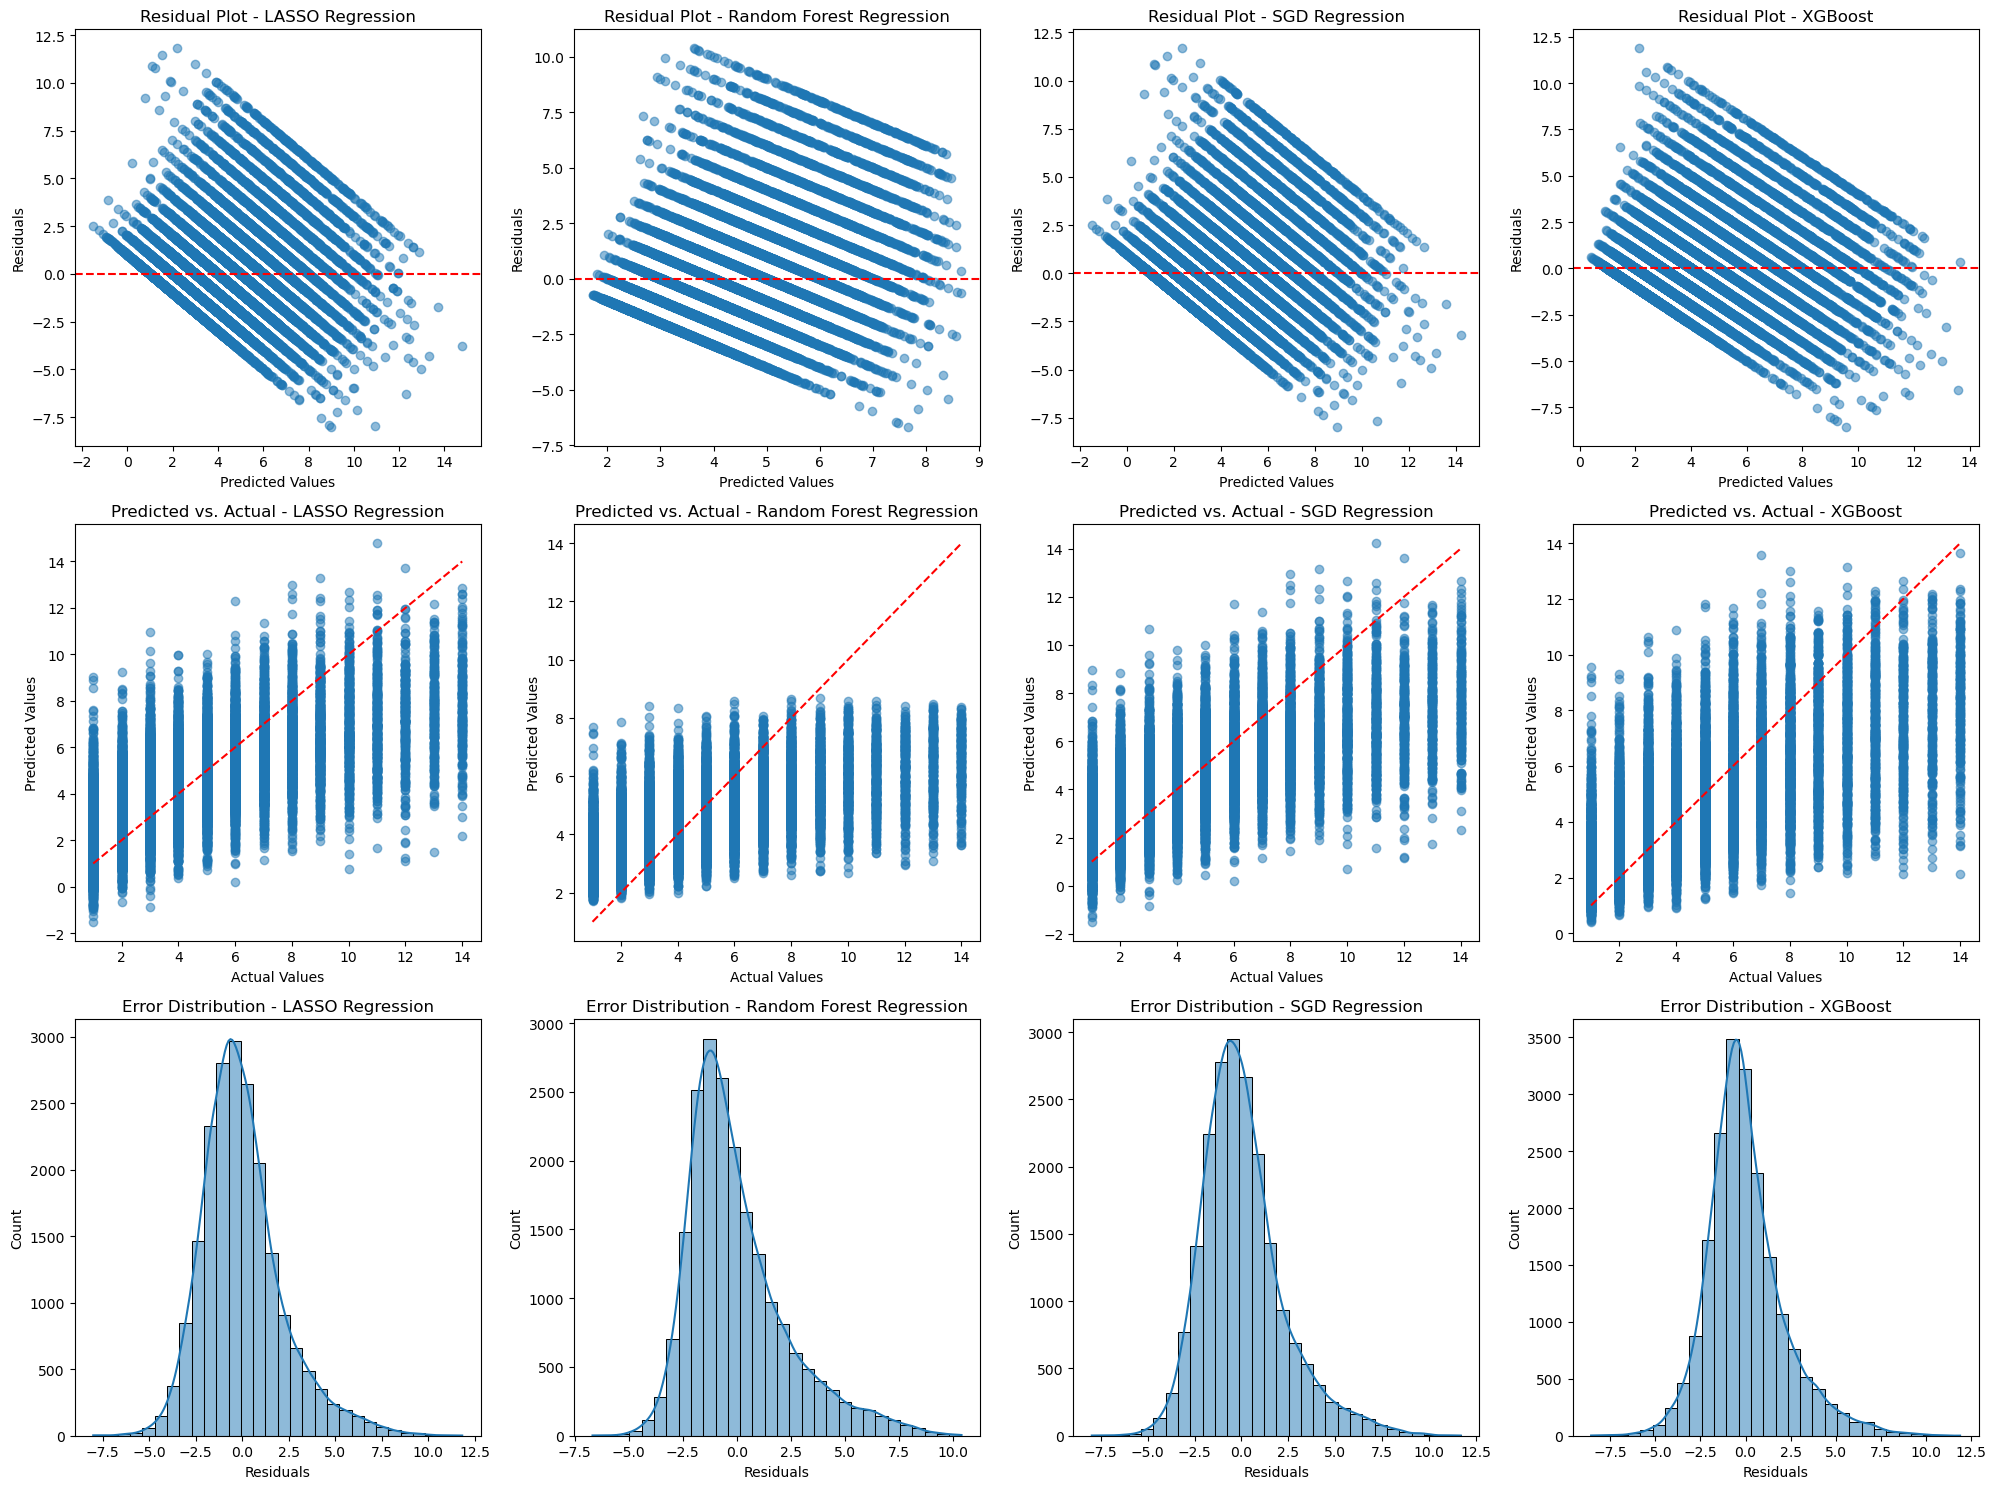

In [17]:
# Define regression models & labels
regressors = [lasso_pipeline, rf_model, sgd_pipeline, xgb_model]
reg_labels = ['LASSO Regression', 'Random Forest Regression', 'SGD Regression', 'XGBoost']

# Create subplots (3 rows: Residuals, Predicted vs Actual, Error Distribution)
fig, axes = plt.subplots(3, len(regressors), figsize=(len(regressors) * 5, 15))

for i, (model, label) in enumerate(zip(regressors, reg_labels)):
    
    # Predictions
    y_test_pred = model.predict(X_test_selected)
    residuals = y_test - y_test_pred  # Compute residuals (errors)

    # ---- Residual Plot ----
    axes[0, i].scatter(y_test_pred, residuals, alpha=0.5)
    axes[0, i].axhline(y=0, color="r", linestyle="--")  # Reference line at 0
    axes[0, i].set_title(f"Residual Plot - {label}")
    axes[0, i].set_xlabel("Predicted Values")
    axes[0, i].set_ylabel("Residuals")

    # ---- Predicted vs. Actual ----
    axes[1, i].scatter(y_test, y_test_pred, alpha=0.5)
    axes[1, i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
    axes[1, i].set_title(f"Predicted vs. Actual - {label}")
    axes[1, i].set_xlabel("Actual Values")
    axes[1, i].set_ylabel("Predicted Values")

    # ---- Error Distribution ----
    sns.histplot(residuals, bins=30, kde=True, ax=axes[2, i])
    axes[2, i].set_title(f"Error Distribution - {label}")
    axes[2, i].set_xlabel("Residuals")

plt.tight_layout()
plt.show()


#### Plot Learning Curves

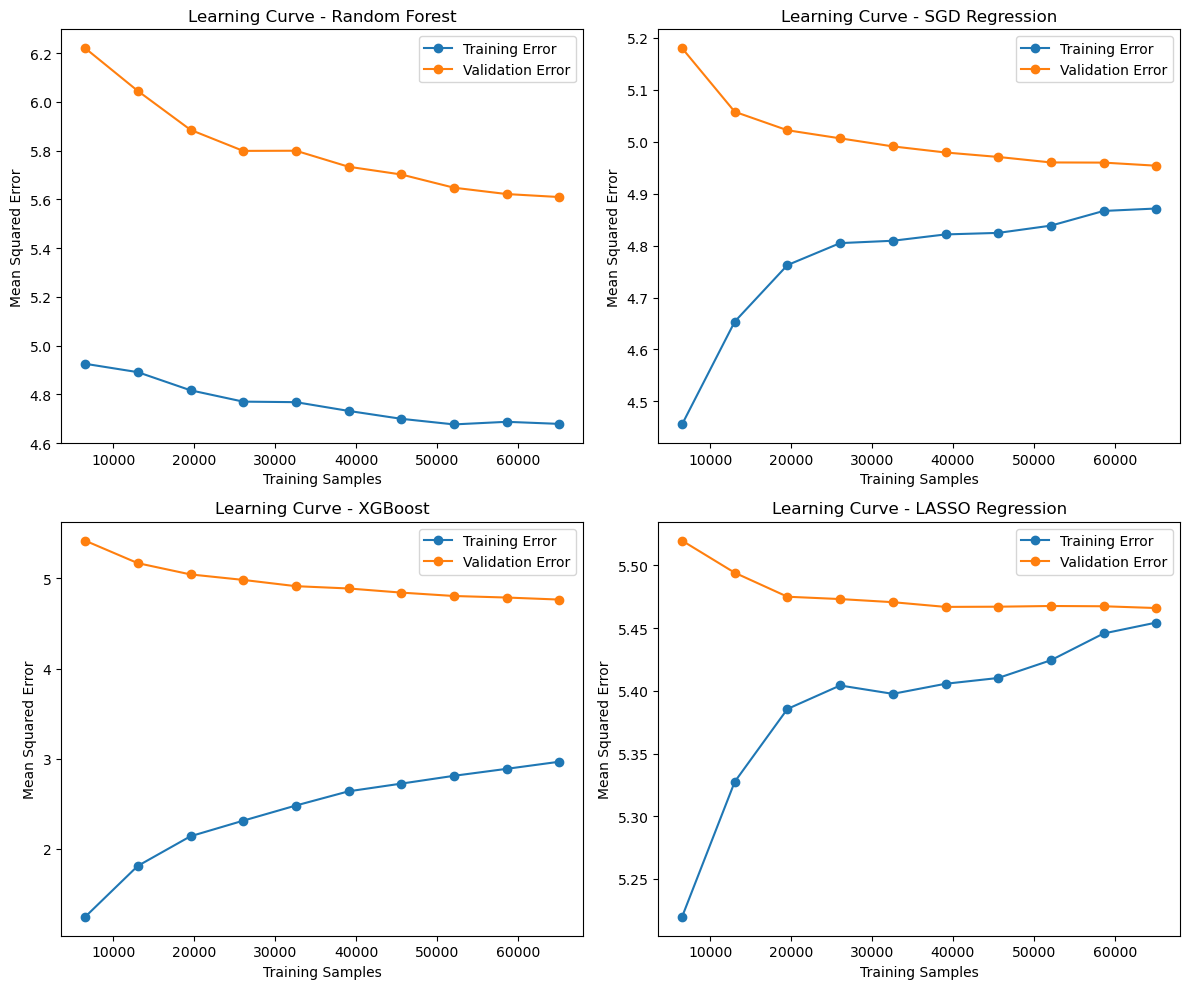

In [18]:
from sklearn.model_selection import learning_curve

# Apply fixes: Increase iterations, ensure scaling, and adjust alpha
lasso_pipeline.set_params(reg__max_iter=5000, reg__alpha=0.01)

# Function to plot learning curves
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="neg_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Convert scores to positive MSE
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training Error")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Validation Error")
    plt.xlabel("Training Samples")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.legend(loc="best")

# Plot for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models = {
    "LASSO Regression": lasso_pipeline,
    "Random Forest": rf_model,
    "SGD Regression": sgd_pipeline,
    "XGBoost": xgb_model
}

for ax, (name, model) in zip(axes.ravel(), models.items()):
    plot_learning_curve(model, X_train_selected, y_train, f"Learning Curve - {name}")
    plt.sca(ax)

plt.tight_layout()
plt.show()


#### Interpreting the Lasso Model

In [19]:
# Extract the trained LASSO model from the pipeline
lasso_model = lasso_pipeline.named_steps['reg']

# Get feature names from the preprocessor (if applicable)
if 'preprocessor' in lasso_pipeline.named_steps:
    feature_names = list(X_train_selected.columns)  # If no preprocessing was applied
else:
    feature_names = list(X_train_selected.columns)  # Use raw feature names

# Get the coefficients
lasso_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_model.coef_
})

# Remove zero coefficients
lasso_nonzero = lasso_coefficients[lasso_coefficients['Coefficient'] != 0]

# Count number of selected features
num_nonzero_features = lasso_nonzero.shape[0]

# Get top 20 important features (sorted by absolute coefficient value)
top_20_features = lasso_nonzero.assign(AbsCoefficient=lasso_nonzero['Coefficient'].abs()) \
                               .sort_values(by='AbsCoefficient', ascending=False) \
                               .drop(columns=['AbsCoefficient']) \
                               .head(20)

# Print results
print(f"\nTotal Number of Non-Zero Coefficients: {num_nonzero_features}")
print("\nTop 20 Most Important Features in LASSO:")
print(top_20_features)



Total Number of Non-Zero Coefficients: 924

Top 20 Most Important Features in LASSO:
                                       Feature  Coefficient
641                                 diag_1_731     4.803175
528                                 diag_1_583     3.958205
833                                 diag_1_V57     3.850634
126   medical_specialty_Pediatrics_Pulmonology     3.683990
286                                 diag_1_295     3.349534
287                                 diag_1_296     2.785223
186                                 diag_1_161     2.760550
304                                 diag_1_312     2.756563
221                                 diag_1_208     2.616360
830                                 diag_1_V54     2.425186
2297                                diag_3_V53     2.379746
281                                 diag_1_290     2.319377
977                                 diag_2_312     2.298668
298                                 diag_1_307     2.281423
285           

## Deployment

- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

## Exceptional Work

- You have free reign to provide additional modeling.
- One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?